### import data

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
# Read in the car sales data
car_sales = pd.read_csv("data/car-sales-extended-missing-data.csv")

# View the first 5 rows of the car sales data
car_sales.head()

,Make,Colour,Odometer (KM),Doors,Price
0,Honda,White,35431.0,4.0,15323.0
1,BMW,Blue,192714.0,5.0,19943.0
2,Honda,White,84714.0,4.0,28343.0
3,Toyota,White,154365.0,4.0,13434.0
4,Nissan,Blue,181577.0,3.0,14043.0


In [4]:
# Get information about the car sales DataFrame
car_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Make           951 non-null    object 
 1   Colour         950 non-null    object 
 2   Odometer (KM)  950 non-null    float64
 3   Doors          950 non-null    float64
 4   Price          950 non-null    float64
dtypes: float64(3), object(2)
memory usage: 39.2+ KB


In [5]:
# Find number of missing values in each column
car_sales.isna().sum()

Make             49
Colour           50
Odometer (KM)    50
Doors            50
Price            50
dtype: int64

In [6]:
# Find the datatypes of each column of car_sales
car_sales.dtypes

Make              object
Colour            object
Odometer (KM)    float64
Doors            float64
Price            float64
dtype: object

In [7]:
# Remove rows with no labels (NaN's in the Price column)
car_sales.dropna(subset=["Price"], inplace=True)

In [8]:
car_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 950 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Make           903 non-null    object 
 1   Colour         904 non-null    object 
 2   Odometer (KM)  902 non-null    float64
 3   Doors          903 non-null    float64
 4   Price          950 non-null    float64
dtypes: float64(3), object(2)
memory usage: 44.5+ KB


### Building a pipeline

In [9]:
# Import Pipeline from sklearn's pipeline module
from sklearn.pipeline import Pipeline

# Import ColumnTransformer from sklearn's compose module
from sklearn.compose import ColumnTransformer

# Import SimpleImputer from sklearn's impute module
from sklearn.impute import SimpleImputer

# Import OneHotEncoder from sklearn's preprocessing module
from sklearn.preprocessing import OneHotEncoder

# Import train_test_split from sklearn's model_selection module
from sklearn.model_selection import train_test_split

In [10]:
# Define different categorical features 
categorical_features = ["Make", "Colour"]

# Create categorical transformer Pipeline
categorical_transformer = Pipeline(steps=[
    # Set SimpleImputer strategy to "constant" and fill value to "missing"
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    # Set OneHotEncoder to ignore the unknowns
    ("onehot", OneHotEncoder(handle_unknown="ignore"))])

In [11]:
# Define Doors features
door_feature = ["Doors"]

# Create Doors transformer Pipeline
door_transformer = Pipeline(steps=[
    # Set SimpleImputer strategy to "constant" and fill value to 4
    ("imputer", SimpleImputer(strategy="constant", fill_value=4))])

In [12]:
# Define numeric features (only the Odometer (KM) column)
numeric_features = ["Odometer (KM)"]

# Crearte numeric transformer Pipeline
numeric_transformer = Pipeline(steps=[
    # Set SimpleImputer strategy to fill missing values with the "Median"
    ("imputer", SimpleImputer(missing_values=np.nan, strategy="median"))])

In [13]:
# Setup preprocessing steps (fill missing values, then convert to numbers)
preprocessor = ColumnTransformer(
    transformers=[
        # Use the categorical_transformer to transform the categorical_features
        ("cat", categorical_transformer, categorical_features),
        # Use the door_transformer to transform the door_feature
        ("door", door_transformer, door_feature),
        # Use the numeric_transformer to transform the numeric_features
        ("num", numeric_transformer, numeric_features)])

In [14]:
# Import Ridge from sklearn's linear_model module
from sklearn.linear_model import Ridge

# Import SVR from sklearn's svm module
from sklearn.svm import SVR

# Import RandomForestRegressor from sklearn's ensemble module
from sklearn.ensemble import RandomForestRegressor

In [15]:
regression_models = {"Ridge": Ridge(),
                     "SVR_linear": SVR(kernel="linear"),
                     "SVR_rbf": SVR(kernel="rbf"),
                     "RandomForestRegressor": RandomForestRegressor()}

# Create an empty dictionary for the regression results
regression_results = {}

In [16]:
# Create car sales X data (every column of car_sales except Price)
car_sales_X = car_sales.drop("Price", axis=1)

# Create car sales y data (the Price column of car_sales)
car_sales_y = car_sales["Price"]

In [17]:
# training and test sets.
car_X_train, car_X_test, car_y_train, car_y_test = train_test_split(car_sales_X,
                                                                    car_sales_y,
                                                                    test_size=0.2,
                                                                    random_state=42)

# Check the shapes of the training and test datasets
car_X_train.shape, car_X_test.shape, car_y_train.shape, car_y_test.shape

((760, 4), (190, 4), (760,), (190,))

In [18]:
# Loop through the items in the regression_models dictionary
for model_name, model in regression_models.items():
    
    # Create a model Pipeline with a preprocessor step and model step
    model_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                      ("model", model)])
    
    # Fit the model Pipeline to the car sales training data
    print(f"Fitting {model_name}...")
    model_pipeline.fit(car_X_train, car_y_train)
    
    # Score the model Pipeline on the test data appending the model_name to the 
    # results dictionary
    print(f"Scoring {model_name}...")
    regression_results[model_name] = model_pipeline.score(car_X_test, car_y_test)

Fitting Ridge...
Scoring Ridge...
Fitting SVR_linear...
Scoring SVR_linear...
Fitting SVR_rbf...
Scoring SVR_rbf...
Fitting RandomForestRegressor...
Scoring RandomForestRegressor...


In [19]:
# Check the results of each regression model by printing the regression_results
# dictionary
regression_results

{'Ridge': 0.2540261105794388,
 'SVR_linear': -0.489452821008145,
 'SVR_rbf': 0.0018546241516633755,
 'RandomForestRegressor': 0.22090656424005406}

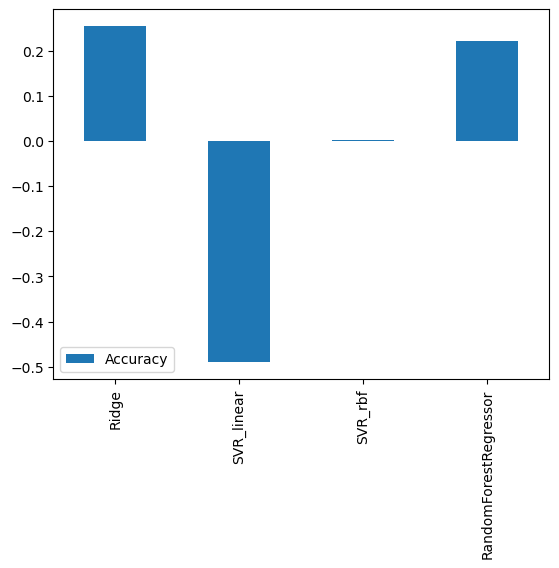

In [27]:
results_df = pd.DataFrame(regression_results.values(), 
                          regression_results.keys(), 
                          columns=["Accuracy"])

# Create a bar plot of the results dataframe using plot.bar()
results_df.plot.bar();

In [20]:
# Import mean_absolute_error from sklearn's metrics module
from sklearn.metrics import mean_absolute_error

# Import mean_squared_error from sklearn's metrics module
from sklearn.metrics import mean_squared_error

# Import r2_score from sklearn's metrics module
from sklearn.metrics import r2_score

In [22]:
# Create RidgeRegression Pipeline with preprocessor as the "preprocessor" and
# Ridge() as the "model".
ridge_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                 ("model", Ridge())])

# Fit the RidgeRegression Pipeline to the car sales training data
ridge_pipeline.fit(car_X_train, car_y_train)

# Make predictions on the car sales test data using the RidgeRegression Pipeline
car_y_preds = ridge_pipeline.predict(car_X_test)

# View the first 50 predictions
car_y_preds[:10]

array([18514.480873  , 22204.86580267, 11045.72092225,  6891.87687957,
        8793.93970278, 10926.96786577, 15267.76229871, 13834.80312146,
       20207.44377898, 14412.59968701])

In [23]:
# Find the MSE by comparing the car sales test labels to the car sales predictions
mse = mean_squared_error(car_y_test, car_y_preds)
# Return the MSE
mse

49950182.633374594

In [24]:
# Find the MAE by comparing the car sales test labels to the car sales predictions
mae = mean_absolute_error(car_y_test, car_y_preds)
# Return the MAE
mae

5713.821520855157

In [25]:
# Find the R^2 score by comparing the car sales test labels to the car sales predictions
r2 = r2_score(car_y_test, car_y_preds)
# Return the R^2 score
r2

0.2540261105794388

### Hyperparameter Tuning

In [39]:
car_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 950 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Make           903 non-null    object 
 1   Colour         904 non-null    object 
 2   Odometer (KM)  902 non-null    float64
 3   Doors          903 non-null    float64
 4   Price          950 non-null    float64
dtypes: float64(3), object(2)
memory usage: 44.5+ KB


In [40]:
car_sales.isna().sum()

Make             47
Colour           46
Odometer (KM)    48
Doors            47
Price             0
dtype: int64

In [41]:
# make the data ready.
# Fill the "Make" column
car_sales["Make"].fillna("missing", inplace=True)

# Fill the "Colour" column
car_sales["Colour"].fillna("missing", inplace=True)

# Fill the "Odometer (KM)" column
car_sales["Odometer (KM)"].fillna(car_sales["Odometer (KM)"].mean(), inplace=True)

# Fill the "Doors" column
car_sales["Doors"].fillna(4, inplace=True)

In [42]:
car_sales.isna().sum()

Make             0
Colour           0
Odometer (KM)    0
Doors            0
Price            0
dtype: int64

In [43]:
car_sales.shape

(950, 5)

In [58]:
# Create car sales X data (every column of car_sales except Price)
car_sales_X = car_sales.drop("Price", axis=1)

# Create car sales y data (the Price column of car_sales)
car_sales_y = car_sales["Price"]

In [59]:
# Turn the categories into numbers
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_features = ["Make", "Colour", "Doors"]
one_hot = OneHotEncoder()
transformer = ColumnTransformer([("one_hot",
                                   one_hot,
                                   categorical_features)],
                                   remainder="passthrough")

car_sales_X = transformer.fit_transform(car_sales_X)
car_sales_X

<950x15 sparse matrix of type '<class 'numpy.float64'>'
	with 3800 stored elements in Compressed Sparse Row format>

In [60]:
# training and test sets.
car_X_train, car_X_test, car_y_train, car_y_test = train_test_split(car_sales_X,
                                                                    car_sales_y,
                                                                    test_size=0.2,
                                                                    random_state=42)

# Check the shapes of the training and test datasets
car_X_train.shape, car_X_test.shape, car_y_train.shape, car_y_test.shape

((760, 15), (190, 15), (760,), (190,))

In [61]:
# Different Ridge hyperparameters
ridge_grid = {'alpha':[1, 20, 80, 100, 150, 200, 250, 500, 1000]}

In [62]:
# Setup np random seed of 42
np.random.seed(42)

# Import RandomizedSearchCV from sklearn's model_selection module
from sklearn.model_selection import RandomizedSearchCV

# Setup an instance of RandomizedSearchCV with a estimator,
ridge_reg = RandomizedSearchCV(estimator=Ridge(),
                                param_distributions=ridge_grid,
                                cv=9,
                                n_iter=5,
                                verbose=True)

# Fit the model Pipeline to the car sales training data
print(f"Fitting ...")
ridge_reg.fit(car_X_train, car_y_train)

# Score the model Pipeline on the test data appending the model_name to the 
ridge_reg.score(car_X_test, car_y_test)

Fitting ...
Fitting 9 folds for each of 5 candidates, totalling 45 fits


0.13909515549836748

In [64]:
# Make predictions on the car sales test data using the RidgeRegression
car_y_preds = ridge_reg.predict(car_X_test)

# View the first 50 predictions
car_y_preds[:10]

array([17820.28958339, 21979.87366269, 12841.00510774, 10912.16366532,
       11112.04097236, 10301.24096524, 17295.57350791, 14991.38994707,
       21539.48241544, 16232.13225184])

In [65]:
# Find the MSE by comparing the car sales test labels to the car sales predictions
mse = mean_squared_error(car_y_test, car_y_preds)
# Return the MSE
print(mse)
# Find the MAE by comparing the car sales test labels to the car sales predictions
mae = mean_absolute_error(car_y_test, car_y_preds)
# Return the MAE
print(mae)
# Find the R^2 score by comparing the car sales test labels to the car sales predictions
r2 = r2_score(car_y_test, car_y_preds)
# Return the R^2 score
print(r2)

57645924.10361143
6012.798638623536
0.13909515549836748


In [67]:
## woow
import pickle

# Save an extisting model to file
pickle.dump(ridge_reg, open("test_regression_car_sales_model.pkl", "wb"))